# Topic Analysis Approach

In Topic Analysis Approach, we are using the essays.csv as our data, which only contains the essays columns and doesn't have other features. This means when we do match making with it, it is possible we mismatch people, as we are not able to indentify user's sex and the orientation. We assume with further information like sex and orientation, the company can filter the people to recommend in the real application.

We divide the dataset into two parts: (1)**description**, (2) **expectation**. In description, we have essay0 - essay8, where users describes themselves. In expectation, we have essay9, where users write their expectation on their potential match. We will do the same text processing on description and expectation texts to make sure the match is made based on the same vocabulary.

Now let's discuss about how we implement this Topic Analysis Approach step by step.  

    (1) We first processed both description and expectation texts, and we extract 5 keywords from each text with yake.KeywordExtractor (i.e., using 5 keywords to represent description text and using another 5 to represent expectation text for each person).  
                                                                                                                                                                                                                        (2) Then, we do the topic analysis on description text with LDA model. Now we will have several topics summarizing different groups of people's self description. In each topic, we will have a bunch of people that belongs to the topic, and they can be ranked by the probability of belonging to this topic.  
                                                                                                                                                                                                                        (3) Finally, we will use the users' expectaion keywords to match with the topics' top 5 relevant words. To do this, we use google-news-300 Word2Vec to vectorize the expectaion keywords and topics' top 5 relevant words, and calculate the distance between the expectaion keywords and each of the topic relevant words. We select the top 3 closest topics, and we consider the users in these topics as a match to the user with the expection.

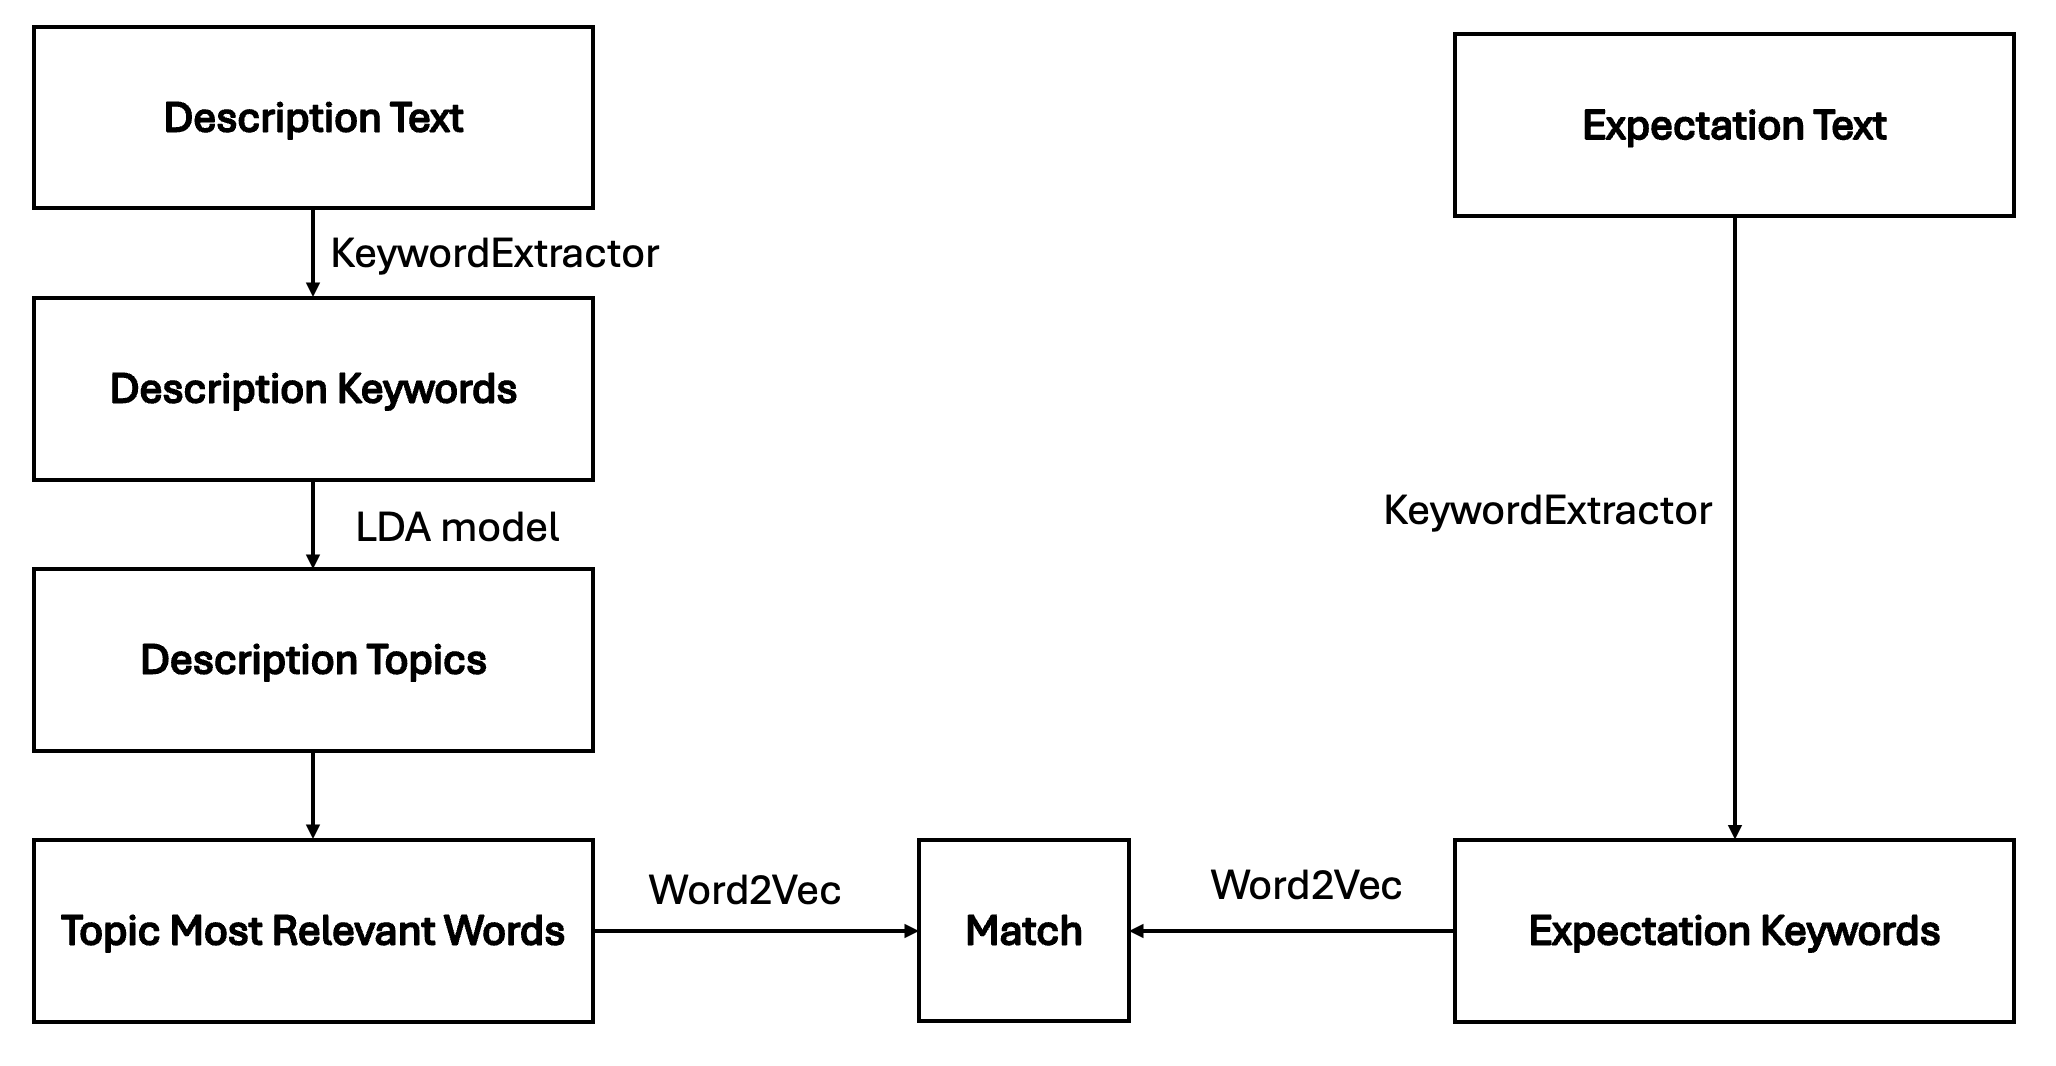

In the following codes, we first do experiment on a sample with size 3000. It's just for us to make sure this approach works and help us understand this workflow, so we don't have to include that in our report.

The application on the full dataset starts from the part "Application on All Data". We evaluate the topic model by the coherence score and the LDA visualiztion (model performs well if there not too much overlap between topics). For the match making, it is hard to evaluate, so we try to show our approach's ability by showing some examples.

# Data Preparation

In [1]:
#dependencies
import numpy as np
import pandas as pd

import random

from matplotlib import pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('omw-1.4')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans

import string
import re

import gensim
from gensim import corpora
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, preprocess_string, stem_text
from gensim.models import LdaMulticore, Word2Vec
from gensim.models.coherencemodel import CoherenceModel

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE

import spacy

!pip install git+https://github.com/LIAAD/yake
import yake

!pip install pyldavis
import pyLDAvis
#import pyLDAvis.gensim
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

from collections import defaultdict

[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


  Cloning https://github.com/LIAAD/yake to /tmp/pip-req-build-h_bu3p9k
  Running command git clone --filter=blob:none --quiet https://github.com/LIAAD/yake /tmp/pip-req-build-h_bu3p9k
  Resolved https://github.com/LIAAD/yake to commit 0fa58cceb465162b6bd0cab7ec967edeb907fbcc
  Preparing metadata (setup.py) ... done


In [2]:
#importing the dataset
essays = pd.read_csv('essays.csv')
essays.head()

,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
0,"well hi there. my mantra this year is ""<a clas...","working, exploring the world, and meeting cool...","playing the <a class=""ilink"" href=""/interests?...",my laugh (if i happen to be laughing (or playi...,"way too many of each to count, so i'll just wr...",a piano<br />\nbig picture windows with panora...,adventures that i've yet to have,"probably working late, then coming home to cra...",i named my roomba. philippe and i have had som...,-you believe that community is a gift from the...
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,musician / writer / programmer from the woods ...,"working for startups, destroying dancefloors, ...",taking things apart and fixing them. cooking w...,NaN,my music collection is a little bit out of con...,"lowpass filters, spanish rice, public radio, w...",cosmology and the fate of the universe.,"""you can find me in the club"" - curtis james j...",i've been skating for 6 years and only learned...,"you need some money moved out of nigeria, or i..."
3,nothing in this world can take the place of pe...,i'm committed full-time to my art practice. i ...,painting. observational comedy. finding cool s...,"i'm tall. i don't know, you tell me...","artists- anselm kiefer, peter doig, edvard mun...",-art<br />\n<br />\n-tunes<br />\n<br />\n-npr...,-how i can keep evolving as an artist and pers...,either locked in the studio or out on the town!,i think terry gross' snort when she laughs is ...,"i'm looking to find a good, kind-hearted woman..."
4,"i'm a sweet, sassy, easy going, low femme look...",i'm a public interest lawyer. i am passionate ...,creative cooking projects<br />\nhosting parti...,my curly hair and hopefully my sparkle.,a few favorites: movies + tv = woody allen; fe...,"i could never do without love and community, a...",time with friends somewhere gorgeous and woods...,looking for love in all the wrong places.,sometimes i tend toward hyperbole.,you think i might be interesting and/or cute o...


**Note**  
essay0- My self summary \
essay1- What I’m doing with my life \
essay2- I’m really good at \
essay3- The first thing people usually notice about me \
essay4- Favorite books, movies, show, music, and food \
essay5- The six things I could never do without \
essay6- I spend a lot of time thinking about \
essay7- On a typical Friday night I am \
essay8- The most private thing I am willing to admit \
essay9- You should message me if...

# Text preprocessing

In [3]:
essays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   essay0  54456 non-null  object
 1   essay1  52374 non-null  object
 2   essay2  50308 non-null  object
 3   essay3  48470 non-null  object
 4   essay4  49409 non-null  object
 5   essay5  49096 non-null  object
 6   essay6  46175 non-null  object
 7   essay7  47495 non-null  object
 8   essay8  40720 non-null  object
 9   essay9  47343 non-null  object
dtypes: object(10)
memory usage: 4.6+ MB


As can be seen, there are null values present in the dataset, and we can use typical terms, such as "None" or "N/A" to fill them. However, this will create issues with preprocessing and topic selection later on, so we will use punctuation to maintain visibility of empty values and be able to remove them at the preprocessing stage.

In [4]:
essays = essays.fillna('.')
essays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   essay0  59946 non-null  object
 1   essay1  59946 non-null  object
 2   essay2  59946 non-null  object
 3   essay3  59946 non-null  object
 4   essay4  59946 non-null  object
 5   essay5  59946 non-null  object
 6   essay6  59946 non-null  object
 7   essay7  59946 non-null  object
 8   essay8  59946 non-null  object
 9   essay9  59946 non-null  object
dtypes: object(10)
memory usage: 4.6+ MB


In [5]:
essays["id"] = essays.index

In [6]:
#sample description essay
essays_describe = essays[essays.columns[:-2]]
essays_describe["id"] = essays["id"]
essays_describe.essay0[0]

/tmp/ipykernel_26883/38783980.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  essays_describe["id"] = essays["id"]


'well hi there. my mantra this year is "<a class="ilink" href=\n"/interests?i=explore">explore</a>." that may mean walking down an\nuntrodden path, trying russian food, visiting another continent, or\njust staring at a snail to see who blinks first. it may be a\nstrange year, but it won\'t be boring.'

In [7]:
#sample expectation essay
essays_expect = essays[essays.columns[-2:]]
essays_expect.essay9[0]

'-you believe that community is a gift from the comedy gods.<br />\n-you are not above the occasional (or frequent) nerdy\npursuit.<br />\n-you can think up a good punchline to "a cat walks in to a bar."\nseriously it\'s bugging the crap out of me.<br />\n-you have a strong opinion about the oxford comma.<br />\n-you can\'t think of a good reason not to.'

As the original dataset consists of 59946 rows of data, it will be problematic to process all at once. To simplify the process, we select a number of random samples without replacement (3000, approximately 5% of the data). No random state is assigned to see the impact sample variations will have on model coherence.

## Description Text

In [8]:
#aggregating user-generated essays
description = []
for i in range(59946):
    description.append(''.join(essays_describe.iloc[i,:-2]))
essays_describe['description_texts'] = description
sample = essays_describe[['id','description_texts']].sample(n=3000, replace=False, random_state=42)
sample = sample.reset_index(drop=True)
sample[0:10]

,id,description_texts
0,4800,i'm chasing my dreams like there's no tomorrow...
1,56896,"*if you are going to message me, please at lea..."
2,17834,i just moved back to san francisco after seven...
3,27275,currently staying with family in burlingame. i...
4,3335,"a friend once made a shirt for me. it said, ""i..."
5,45352,my dad was a jack-of-all trades and i think i ...
6,9030,i am a free spirit who is always up for a wild...
7,13863,"born and raised in curacao, n.a. -, lived in h..."
8,23413,"i've got a american culture wearing jeans, boo..."
9,27778,finally completing this profile (almost) prope...


In [9]:
#text preprocessing
nlp = spacy.load('en_core_web_sm')
all_stopwords = nlp.Defaults.stop_words
all_stopwords.add("love")

sample['description_texts'] = sample['description_texts'].apply(lambda x: remove_stopwords(x))
sample_tokens = sample['description_texts'].apply(lambda x: word_tokenize(x))

sample_clean = sample_tokens.apply(lambda text: " ".join(i for i in text if i not in all_stopwords))
sample_np = sample_clean.apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))
sample_np = sample_np.apply(lambda x: x.lower().strip())
sample_np = sample_np.apply(lambda x: remove_stopwords(x)) #second pass for certainty

In [10]:
#to gauge text similarity both lemmatisation and stemming were used, with stemming giving more consistent results

sample_stemmed = sample_np.apply(lambda x: stem_text(x))
sample['stems'] = sample_stemmed
sample['stems'][0:10]

# lemmatizer = WordNetLemmatizer()
# sample_lems = sample_np.apply(lambda x: lemmatizer.lemmatize(x))
# sample['lems'] = sample_lems
# sample_lems[0:10]

0    chase dream like tomorrow optim level chart su...
1    go messag hi cool tat messag get kind old br b...
2    move san francisco seven year seattl br br com...
3    current stai famili burlingam oldest 6 kid 5 g...
4    friend shirt said built world social quot bask...
5    dad jackofal trade think inherit qualiti hinds...
6    free spirit wild crazi adventur recent move sa...
7    born rais curacao na live holland 7 year san f...
8    got american cultur wear jean boot countryboi ...
9    final complet profil properli work progress lo...
Name: stems, dtype: object

## Expectation Text

In [11]:
#aggregating user-generated essays
essays_expect['expectation_texts'] = essays_expect["essay9"]
sample_exp = essays_expect[['id','expectation_texts']].sample(n=3000, replace=False, random_state=42)
sample_exp = sample_exp.reset_index(drop=True)
sample_exp[0:10]

/tmp/ipykernel_26883/2554254546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  essays_expect['expectation_texts'] = essays_expect["essay9"]


,id,expectation_texts
0,4800,you want to find out more about me and you wan...
1,56896,-you don't care that i have tattoos.<br />\n-y...
2,17834,if my geekiness hasn't overwhelmed you yet.<br...
3,27275,you want to???
4,3335,.
5,45352,"if you are cool, enjoy the outdoors, own a bik..."
6,9030,you are up for a new and exciting adventure. :...
7,13863,you want to
8,23413,.
9,27778,you want to/are looking for a good friend or b...


In [12]:
#text preprocessing
nlp = spacy.load('en_core_web_sm')
all_stopwords = nlp.Defaults.stop_words
all_stopwords.add("love")

sample_exp['expectation_texts'] = sample_exp['expectation_texts'].apply(lambda x: remove_stopwords(x))
sample_tokens = sample_exp['expectation_texts'].apply(lambda x: word_tokenize(x))

sample_clean = sample_tokens.apply(lambda text: " ".join(i for i in text if i not in all_stopwords))
sample_np = sample_clean.apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))
sample_np = sample_np.apply(lambda x: x.lower().strip())
sample_np = sample_np.apply(lambda x: remove_stopwords(x)) #second pass for certainty

In [13]:
#to gauge text similarity both lemmatisation and stemming were used, with stemming giving more consistent results

sample_stemmed = sample_np.apply(lambda x: stem_text(x))
sample_exp['stems'] = sample_stemmed
sample_exp['stems'][0:10]

# lemmatizer = WordNetLemmatizer()
# sample_lems = sample_np.apply(lambda x: lemmatizer.lemmatize(x))
# sample['lems'] = sample_lems
# sample_lems[0:10]

0                                 want want drama free
1    care tattoo br curiou br want new friend br la...
2    geeki overwhelm br br smart happi honest attra...
3                                                 want
4                                                     
5    cool enjoi outdoor bike afraid us uptight prea...
6        new excit adventur br br tattoo gui littl edg
7                                                 want
8                                                     
9               want toar look good friend bosom buddi
Name: stems, dtype: object

# Keyword extraction

Unlike purposefully created text data, e.g. news items or academic articles, the essays do not have a uniform aim or rather, the aim is to represent the user in terms of being desirable. This can involve a wide range of linguistic, and sometimes paralinguistic means that hinder classification. Therefore, we propose to further standartize the data by selecting only relevant keywords and using them for corpus creation and analysis. To do this, YAKE keyword extractor was used.

In [14]:
#Extracted keyword strings
yaxtract_mod = yake.KeywordExtractor(lan='en', n=1, dedupLim=0.7, top=5, dedupFunc='seqm', windowsSize=1)


keywords = sample[['id','stems']]
keywords['stems'] = keywords['stems'].apply(lambda x: yaxtract_mod.extract_keywords(x))
keywords['stems_clean'] = keywords['stems'].apply(lambda i: list(dict(i).keys()))

keywords['stems_clean'] = keywords['stems_clean'].apply(lambda x: ' '.join(x))

keywords['stems_clean'][0:10]

/tmp/ipykernel_26883/2696371281.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keywords['stems'] = keywords['stems'].apply(lambda x: yaxtract_mod.extract_keywords(x))


0             chase friend person dream tomorrow
1                   learn enjoi thing home peopl
2                    good world pretti life work
3                     kid girl work food current
4                 friend humor shirt built world
5                  bike movi differ music school
6                    work year music food friend
7               event danc dinner parti industri
8    nashvil singersongwrit form friend american
9                 pretti friend rock work cupcak
Name: stems_clean, dtype: object

In [15]:
yaxtract_mod = yake.KeywordExtractor(lan='en', n=1, dedupLim=0.7, top=5, dedupFunc='seqm', windowsSize=1)


keywords_exp = sample_exp[['id','stems']]
keywords_exp['stems'] = keywords_exp['stems'].apply(lambda x: yaxtract_mod.extract_keywords(x))
keywords_exp['stems_clean'] = keywords_exp['stems'].apply(lambda i: list(dict(i).keys()))

keywords_exp['stems_clean'] = keywords_exp['stems_clean'].apply(lambda x: ' '.join(x))

keywords_exp['keyword_list'] = keywords_exp['stems'].apply(lambda x: [pair[0] for pair in x])

keywords_exp['stems_clean'][0:10]

/tmp/ipykernel_26883/1492445625.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keywords_exp['stems'] = keywords_exp['stems'].apply(lambda x: yaxtract_mod.extract_keywords(x))


0                            free drama
1      care mannnn tattoo curiou friend
2    happi geeki direct overwhelm smart
3                                      
4                                      
5       cool attract mind enjoi outdoor
6         edg excit adventur tattoo gui
7                                      
8                                      
9          buddi toar good friend bosom
Name: stems_clean, dtype: object

In [16]:
keywords_exp.head()

,id,stems,stems_clean,keyword_list
0,4800,"[(free, 0.09568045026443411), (drama, 0.158316...",free drama,"[free, drama]"
1,56896,"[(care, 0.06341998722529081), (mannnn, 0.06341...",care mannnn tattoo curiou friend,"[care, mannnn, tattoo, curiou, friend]"
2,17834,"[(happi, 0.061963086853876734), (geeki, 0.0743...",happi geeki direct overwhelm smart,"[happi, geeki, direct, overwhelm, smart]"
3,27275,[],,[]
4,3335,[],,[]


# Topic Analysis on Description

In [17]:
#building the corpus and dictionaries
kwd_corpus = keywords['stems_clean'].apply(lambda x: word_tokenize(x))
kwd_dicts = corpora.Dictionary(kwd_corpus)

kwd_bow = [kwd_dicts.doc2bow(i) for i in kwd_corpus]

In [18]:
#LDA model based on keywords
kwd_lda=gensim.models.LdaMulticore(kwd_bow, num_topics=95, id2word=kwd_dicts, passes=2, random_state=1)

# for index,topic in lda.print_topics(-1):
#     print("Topic: {} \nIdeas: {}".format(index, topic))
#     print("\n")

In [19]:
coherence_model = CoherenceModel(model=kwd_lda, texts=kwd_corpus, dictionary=kwd_dicts, coherence='c_v')
coherence_score = coherence_model.get_coherence()
coherence_score

0.622803235061876

In [20]:
#visualizing the topics
pyLDAvis.gensim_models.prepare(kwd_lda, kwd_bow, kwd_dicts, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
27    -0.409968 -0.367315       1        1  6.345075
65    -0.459012  0.197807       2        1  5.641211
17    -0.384007  0.280195       3        1  5.242694
66    -0.463039 -0.037130       4        1  5.019189
63    -0.474010  0.143070       5        1  4.735586
...         ...       ...     ...      ...       ...
31     0.082788 -0.009114      91        1  0.284911
30     0.082788 -0.009114      92        1  0.284911
24     0.082788 -0.009114      93        1  0.284911
23     0.064663  0.004396      94        1  0.284911
0      0.082788 -0.009114      95        1  0.284911

[95 rows x 5 columns], topic_info=      Term        Freq       Total Category  logprob  loglift
10    good  532.000000  532.000000  Default  30.0000  30.0000
2   friend  591.000000  591.000000  Default  29.0000  29.0000
8    peopl  440.000000  440.000000  Default  28.0000  28.0000
13    work  508.000000  508.000000  Default  27.0000  27.0000
25   music  475.000000  475.000000  Default  26.0000  26.0000
..     ...         ...         ...      ...      ...      ...
14   world    0.019548   93.499998  Topic95  -7.6464  -2.6121
16    food    0.019548  212.770525  Topic95  -7.6464  -3.4344
18     kid    0.019548   27.347995  Topic95  -7.6464  -1.3828
22    bike    0.019548    1.998275  Topic95  -7.6464   1.2336
24    movi    0.019548  286.126909  Topic95  -7.6464  -3.7306

[4548 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
646      53  0.640037      accent
934       3  0.604409  accomplish
1095     47  0.685773         air
93        1  0.105612         amp
93        8  0.347011         amp
...     ...       ...         ...
27       14  0.273160        year
27       15  0.324088        year
236      47  0.858246        yoga
1610     20  0.671804     zealand
889      51  0.452812       zombi

[463 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[28, 66, 18, 67, 64, 5, 51, 19, 30, 34, 48, 2, 88, 37, 47, 54, 4, 82, 45, 91, 10, 15, 71, 72, 73, 26, 27, 94, 78, 12, 86, 53, 3, 43, 29, 40, 17, 6, 39, 61, 83, 65, 80, 49, 7, 44, 70, 36, 69, 92, 95, 85, 59, 58, 13, 52, 77, 22, 79, 21, 81, 20, 16, 84, 87, 14, 75, 89, 90, 11, 9, 93, 8, 76, 74, 50, 23, 46, 55, 56, 57, 60, 42, 62, 63, 41, 38, 35, 33, 68, 32, 31, 25, 24, 1])

# Match Making

In [21]:
import numpy as np
from gensim.models import KeyedVectors
from collections import defaultdict
from scipy.spatial.distance import cosine
import gensim.downloader as api

# Use Google News 300 as our Word2Vec model
model = api.load('word2vec-google-news-300') 

def get_average_embedding(tokens, word_vectors):
    valid_vectors = [word_vectors[word] for word in tokens if word in word_vectors]
    
    if not valid_vectors:  
        return np.random.rand(word_vectors.vector_size)

    return np.mean(valid_vectors, axis=0)

# Match the expectation text to the desription topics

def match_text_to_topics(new_text_tokens, topic_keywords, word_vectors, top_n=3):
    """
    计算新文本与每个 LDA 主题的 word embedding 距离，并返回最接近的 3 个主题。
    
    保证即使 `new_text_tokens` 无法匹配任何主题，也返回 `top_n` 主题。

    :param new_text_tokens: 新文本 token 集合 (set)
    :param topic_keywords: 主题关键词 {topic_id: set(关键词)}
    :param word_vectors: Word2Vec 词向量（使用 `model.wv`）
    :param top_n: 返回最接近的前 top_n 个主题
    :return: List of (topic_id, similarity_score)，按相似度降序排序
    """
    topic_scores = defaultdict(float)

    # 计算新文本的平均 embedding
    new_text_vector = get_average_embedding(new_text_tokens, word_vectors)

    for topic_id, keywords in topic_keywords.items():
        # 计算该主题的平均 embedding
        topic_vector = get_average_embedding(keywords, word_vectors)

        # 计算余弦相似度（避免零向量导致错误）
        similarity = 1 - cosine(new_text_vector, topic_vector)

        # 存储相似度得分
        topic_scores[topic_id] = similarity

    # 选择最接近的 top_n 个主题
    sorted_topics = sorted(topic_scores.items(), key=lambda x: x[1], reverse=True)

    # 确保返回非空结果
    if not sorted_topics:
        sorted_topics = [(topic_id, 0.0) for topic_id in list(topic_keywords.keys())[:top_n]]

    return sorted_topics[:top_n]  # 只返回最相似的 top_n 个主题


In [22]:
# get the most relevent words for each topic 

def get_topic_keywords_dict(lda_model, dictionary, num_words=5):
    topic_keywords = {}

    for topic_id in range(lda_model.num_topics):
        # 获取每个主题前 num_words 个最重要的词 (word_id, 权重)
        word_ids = [word_id for word_id, _ in lda_model.get_topic_terms(topic_id, topn=num_words)]
        
        # 将词 ID 映射回原始单词，并存入 set 以便后续匹配
        words = {dictionary[id] for id in word_ids}
        
        # 存储到字典中
        topic_keywords[topic_id] = words
    
    return topic_keywords

In [23]:
topic_keywords = get_topic_keywords_dict(kwd_lda, kwd_dicts, num_words=5)

In [24]:
keywords_exp["match"] = keywords_exp["keyword_list"].apply(lambda x: match_text_to_topics(set(x),topic_keywords, model))
keywords_exp

,id,stems,stems_clean,keyword_list,match
0,4800,"[(free, 0.09568045026443411), (drama, 0.158316...",free drama,"[free, drama]","[(4, 0.34311264688575216), (11, 0.335275248011..."
1,56896,"[(care, 0.06341998722529081), (mannnn, 0.06341...",care mannnn tattoo curiou friend,"[care, mannnn, tattoo, curiou, friend]","[(93, 0.5254553513316041), (38, 0.516716448045..."
2,17834,"[(happi, 0.061963086853876734), (geeki, 0.0743...",happi geeki direct overwhelm smart,"[happi, geeki, direct, overwhelm, smart]","[(68, 0.5202743641176988), (6, 0.4081108437976..."
3,27275,[],,[],"[(72, 0.06803657943961139), (82, 0.04711479579..."
4,3335,[],,[],"[(5, 0.06756999330537772), (89, 0.052250531730..."
...,...,...,...,...,...
2995,8035,"[(messag, 0.12396765710001131), (leav, 0.17416...",messag leav unansw respond awai,"[messag, leav, unansw, respond, awai]","[(81, 0.31797744207626377), (66, 0.31785903458..."
2996,457,"[(date, 0.09568045026443411), (fun, 0.15831692...",date fun posit sens humor,"[date, fun, posit, sens, humor]","[(42, 0.5470314719017012), (87, 0.543509093487..."
2997,46880,"[(wan, 0.15831692877998726)]",wan,[wan],"[(10, 0.4267141992582031), (0, 0.3798288948743..."
2998,50255,[],,[],"[(82, 0.026681408194523915), (66, 0.0257670960..."


Now we have done the match of user's expetation and description topics. In the last column "match", we will have the top 3 matching description topics for each user based on ther expectation. For example, in row 0, we can consider all users in topic 4,11 (and another one unseen) are the matched users for user 4800. In the final application, we retrieve only some of these users and recommend them to the targeted user.

# Application on All Data

All steps are the same as before. We only change the num_topics in LDA model to make it fit better. Coherence Score decreased to 0.44 but it's still acceptable.

In [25]:
# describe
essays_describe['description_texts'] = essays_describe['description_texts'].apply(lambda x: remove_stopwords(x))
describe_tokens = essays_describe['description_texts'].apply(lambda x: word_tokenize(x))

describe_tokens_clean = describe_tokens.apply(lambda text: " ".join(i for i in text if i not in all_stopwords))
describe_np = describe_tokens_clean.apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))
describe_np = describe_np.apply(lambda x: x.lower().strip())
describe_np = describe_np.apply(lambda x: remove_stopwords(x))
describe_stemmed = describe_np.apply(lambda x: stem_text(x))
essays_describe['stems'] = describe_stemmed

# expect
essays_expect['expectation_texts'] = essays_expect['expectation_texts'].apply(lambda x: remove_stopwords(x))
expect_tokens = essays_expect['expectation_texts'].apply(lambda x: word_tokenize(x))

expect_tokens_clean = expect_tokens.apply(lambda text: " ".join(i for i in text if i not in all_stopwords))
expect_np = expect_tokens_clean.apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))
expect_np = expect_np.apply(lambda x: x.lower().strip())
expect_np = expect_np.apply(lambda x: remove_stopwords(x))
expect_stemmed = expect_np.apply(lambda x: stem_text(x))
essays_expect['stems'] = expect_stemmed

/tmp/ipykernel_26883/2230814038.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  essays_expect['expectation_texts'] = essays_expect['expectation_texts'].apply(lambda x: remove_stopwords(x))
/tmp/ipykernel_26883/2230814038.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  essays_expect['stems'] = expect_stemmed


In [26]:
#Extracted keyword strings
yaxtract_mod = yake.KeywordExtractor(lan='en', n=1, dedupLim=0.7, top=5, dedupFunc='seqm', windowsSize=1)

# describe
keywords = essays_describe[['id','stems']]
keywords['stems'] = keywords['stems'].apply(lambda x: yaxtract_mod.extract_keywords(x))
keywords['stems_clean'] = keywords['stems'].apply(lambda i: list(dict(i).keys()))

keywords['stems_clean'] = keywords['stems_clean'].apply(lambda x: ' '.join(x))

# expect
keywords_exp = essays_expect[['id','stems']]
keywords_exp['stems'] = keywords_exp['stems'].apply(lambda x: yaxtract_mod.extract_keywords(x))
keywords_exp['stems_clean'] = keywords_exp['stems'].apply(lambda i: list(dict(i).keys()))

keywords_exp['stems_clean'] = keywords_exp['stems_clean'].apply(lambda x: ' '.join(x))

keywords_exp['keyword_list'] = keywords_exp['stems'].apply(lambda x: [pair[0] for pair in x])

/tmp/ipykernel_26883/2188910999.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keywords['stems'] = keywords['stems'].apply(lambda x: yaxtract_mod.extract_keywords(x))
/tmp/ipykernel_26883/2188910999.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keywords['stems_clean'] = keywords['stems'].apply(lambda i: list(dict(i).keys()))
/tmp/ipykernel_26883/2188910999.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [27]:
#building the corpus and dictionaries
kwd_corpus = keywords['stems_clean'].apply(lambda x: word_tokenize(x))
kwd_dicts = corpora.Dictionary(kwd_corpus)

kwd_bow = [kwd_dicts.doc2bow(i) for i in kwd_corpus]

In [28]:
#LDA model based on keywords
kwd_lda=gensim.models.LdaMulticore(kwd_bow, num_topics=78, id2word=kwd_dicts, passes=2, random_state=1)

In [29]:
topic_keywords = get_topic_keywords_dict(kwd_lda, kwd_dicts, num_words=5)

## Evaluation

Here we use C_V coherence score and visualization to evaluate our LDA model.

Coherence Score measures the semantic similarity between high-probability words within a topic, helping determine whether the topics are meaningful and interpretable. Here we specifically use C_V Coherence, which is based on word embedding similarity and cosine similarity between top words in a topic. It is usually better aligned with human judgments of topic quality.

Visualization can help us evaluate the LDA model qualitatively. We can observe topic overlap, topic size and topic distribution in the plot. With a good LDA model, we can observe well-separated, non-overlapping, and evenly distributed topics.

In [30]:
# Check coherence score
coherence_model = CoherenceModel(model=kwd_lda, texts=kwd_corpus, dictionary=kwd_dicts, coherence='c_v')
coherence_score = coherence_model.get_coherence()
coherence_score

0.44821949016079377

In [31]:
# LDA model visualizaiton
pyLDAvis.gensim_models.prepare(kwd_lda, kwd_bow, kwd_dicts, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
37     0.531510  0.209631       1        1  6.051377
67     0.165027 -0.472440       2        1  3.750012
76     0.339097 -0.306075       3        1  3.582279
70     0.314657  0.425434       4        1  3.322350
50     0.308786 -0.249186       5        1  3.008347
...         ...       ...     ...      ...       ...
47    -0.175366  0.094460      74        1  0.301769
6     -0.175366  0.094460      75        1  0.301769
9     -0.175366  0.094460      76        1  0.301769
30    -0.175366  0.094460      77        1  0.301769
20    -0.175366  0.094460      78        1  0.301769

[78 rows x 5 columns], topic_info=      Term          Freq         Total Category  logprob  loglift
19   peopl   9993.000000   9993.000000  Default  30.0000  30.0000
8    thing   9509.000000   9509.000000  Default  29.0000  29.0000
39    life   7948.000000   7948.000000  Default  28.0000  28.0000
6    music  11294.000000  11294.000000  Default  27.0000  27.0000
22  friend  14140.000000  14140.000000  Default  26.0000  26.0000
..     ...           ...           ...      ...      ...      ...
25   enjoi      0.071042   4589.345892  Topic78  -9.4065  -5.2727
26   place      0.071042    821.200234  Topic78  -9.4065  -3.5520
27    read      0.071042   2816.362538  Topic78  -9.4065  -4.7844
28  social      0.071042    378.711913  Topic78  -9.4065  -2.7780
29   world      0.071042   1930.374292  Topic78  -9.4065  -4.4067

[3755 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1581     60  0.386788        abel
701      65  0.962918     absolut
4453      8  0.399505  accentmovi
191      22  0.020858       activ
191      45  0.974658       activ
...     ...       ...         ...
74       60  0.004810        year
74       70  0.000240        year
576      69  0.996669        yoga
4737     62  0.725188      yogurt
561      35  0.898499       youth

[846 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[38, 68, 77, 71, 51, 20, 17, 67, 24, 30, 22, 23, 39, 69, 74, 36, 32, 50, 53, 19, 18, 47, 8, 59, 54, 11, 1, 9, 42, 56, 43, 33, 14, 60, 34, 73, 4, 41, 61, 16, 15, 40, 63, 70, 78, 35, 2, 52, 62, 27, 45, 44, 46, 75, 64, 5, 58, 49, 66, 6, 57, 12, 26, 28, 55, 37, 72, 29, 25, 13, 65, 3, 76, 48, 7, 10, 31, 21])

In [32]:
keywords_exp["match"] = keywords_exp["keyword_list"].apply(lambda x: match_text_to_topics(set(x),topic_keywords,model))
keywords_exp

,id,stems,stems_clean,keyword_list,match
0,0,"[(good, 0.05009774154849053), (believ, 0.07573...",good believ reason commun gift,"[good, believ, reason, commun, gift]","[(70, 0.5923129748484379), (21, 0.581017776049..."
1,1,[],,[],"[(2, 0.08214137555400691), (9, 0.0821413755540..."
2,2,"[(quot, 0.15831692877998726), (cent, 0.1583169...",quot cent lyric monei move,"[quot, cent, lyric, monei, move]","[(52, 0.42081167278373943), (26, 0.40827586542..."
3,3,"[(messag, 0.0659232579117826), (art, 0.0659232...",messag art explor wwwyoutubecomwatch good,"[messag, art, explor, wwwyoutubecomwatch, good]","[(41, 0.6379150361146894), (68, 0.567311540240..."
4,4,"[(interest, 0.13209142901998333), (relationshi...",interest relationship andor cute intrigu,"[interest, relationship, andor, cute, intrigu]","[(59, 0.5114637650976018), (70, 0.469894959685..."
...,...,...,...,...,...
59941,59941,"[(okai, 0.10923981997294611), (messag, 0.12834...",okai messag mayb great convers,"[okai, messag, mayb, great, convers]","[(54, 0.6114721305038594), (21, 0.604971735752..."
59942,59942,"[(honest, 0.15831692877998726), (creativ, 0.15...",honest creativ confid sexi,"[honest, creativ, confid, sexi]","[(21, 0.5425433655970509), (70, 0.529000503809..."
59943,59943,"[(adventur, 0.15831692877998726)]",adventur,[adventur],"[(2, 0.0776978104307231), (9, 0.07769781043072..."
59944,59944,"[(delici, 0.10697254906238414), (good, 0.12522...",delici good victim home cook,"[delici, good, victim, home, cook]","[(50, 0.6312977403701634), (11, 0.604051965963..."


In [33]:
# Get the user id in each topic

from collections import defaultdict

# 获取 LDA 主题分布
doc_topics = [kwd_lda.get_document_topics(doc, minimum_probability=0.05) for doc in kwd_bow]

# 创建 topic_id -> (id, probability) 列表的映射
topic_to_ids = defaultdict(list)

# 遍历每个文档的主题分布
for idx, topics in enumerate(doc_topics):
    if topics:  # 确保文档被分配到至少一个主题
        # 选择概率最高的主题
        main_topic, main_prob = max(topics, key=lambda x: x[1])
        topic_to_ids[main_topic].append((keywords.loc[idx, 'id'], main_prob))  # 存储 (id, 主题概率)

# 对每个 `topic_id` 下的 `id` 按 `main_prob` 降序排序
for topic_id in topic_to_ids:
    topic_to_ids[topic_id].sort(key=lambda x: x[1], reverse=True)  # 按概率排序
    topic_to_ids[topic_id] = [item[0] for item in topic_to_ids[topic_id]]  # 只保留 id

# 查看部分结果
for topic_id, ids in list(topic_to_ids.items())[:5]:
    print(f"Topic {topic_id}: {ids[:10]}")  # 仅打印前 10 个 id 以便检查

Topic 37: [52936, 240, 436, 598, 604, 788, 918, 990, 1010, 1036]
Topic 70: [5228, 39962, 27870, 8774, 21938, 57403, 706, 1038, 2336, 2589]
Topic 8: [12054, 5248, 40160, 45747, 14025, 53114, 12052, 46651, 56915, 48164]
Topic 68: [28052, 17787, 26872, 53573, 53231, 21943, 168, 2199, 3325, 9469]
Topic 73: [25579, 40206, 797, 4685, 10041, 10265, 14091, 14221, 14860, 18593]


In [34]:
# Only mapping 5 id from each topic
keywords_exp["match_id"] = keywords_exp["match"].apply(lambda x: [topic_to_ids[pair[0]][:5] for pair in x])
keywords_exp

,id,stems,stems_clean,keyword_list,match,match_id
0,0,"[(good, 0.05009774154849053), (believ, 0.07573...",good believ reason commun gift,"[good, believ, reason, commun, gift]","[(70, 0.5923129748484379), (21, 0.581017776049...","[[5228, 39962, 27870, 8774, 21938], [58279, 38..."
1,1,[],,[],"[(2, 0.08214137555400691), (9, 0.0821413755540...","[[], [], []]"
2,2,"[(quot, 0.15831692877998726), (cent, 0.1583169...",quot cent lyric monei move,"[quot, cent, lyric, monei, move]","[(52, 0.42081167278373943), (26, 0.40827586542...","[[1664, 14569, 24728, 57945, 38749], [6666, 55..."
3,3,"[(messag, 0.0659232579117826), (art, 0.0659232...",messag art explor wwwyoutubecomwatch good,"[messag, art, explor, wwwyoutubecomwatch, good]","[(41, 0.6379150361146894), (68, 0.567311540240...","[[28496, 9502, 32652, 34591, 38995], [28052, 1..."
4,4,"[(interest, 0.13209142901998333), (relationshi...",interest relationship andor cute intrigu,"[interest, relationship, andor, cute, intrigu]","[(59, 0.5114637650976018), (70, 0.469894959685...","[[14298, 49019, 53352, 30053, 35336], [5228, 3..."
...,...,...,...,...,...,...
59941,59941,"[(okai, 0.10923981997294611), (messag, 0.12834...",okai messag mayb great convers,"[okai, messag, mayb, great, convers]","[(54, 0.6114721305038594), (21, 0.604971735752...","[[10648, 10230, 57666, 20727, 42745], [58279, ..."
59942,59942,"[(honest, 0.15831692877998726), (creativ, 0.15...",honest creativ confid sexi,"[honest, creativ, confid, sexi]","[(21, 0.5425433655970509), (70, 0.529000503809...","[[58279, 3806, 23890, 5427, 25869], [5228, 399..."
59943,59943,"[(adventur, 0.15831692877998726)]",adventur,[adventur],"[(2, 0.0776978104307231), (9, 0.07769781043072...","[[], [], []]"
59944,59944,"[(delici, 0.10697254906238414), (good, 0.12522...",delici good victim home cook,"[delici, good, victim, home, cook]","[(50, 0.6312977403701634), (11, 0.604051965963...","[[1304, 2491, 4315, 15727, 49107], [7531, 1210..."


In [35]:
# Drop those user who don't have any expectation text
keywords_exp = keywords_exp.drop(keywords_exp[keywords_exp['keyword_list'].apply(lambda x: x == [])].index)
keywords_exp.reset_index(drop=True,inplace=True)
keywords_exp

,id,stems,stems_clean,keyword_list,match,match_id
0,0,"[(good, 0.05009774154849053), (believ, 0.07573...",good believ reason commun gift,"[good, believ, reason, commun, gift]","[(70, 0.5923129748484379), (21, 0.581017776049...","[[5228, 39962, 27870, 8774, 21938], [58279, 38..."
1,2,"[(quot, 0.15831692877998726), (cent, 0.1583169...",quot cent lyric monei move,"[quot, cent, lyric, monei, move]","[(52, 0.42081167278373943), (26, 0.40827586542...","[[1664, 14569, 24728, 57945, 38749], [6666, 55..."
2,3,"[(messag, 0.0659232579117826), (art, 0.0659232...",messag art explor wwwyoutubecomwatch good,"[messag, art, explor, wwwyoutubecomwatch, good]","[(41, 0.6379150361146894), (68, 0.567311540240...","[[28496, 9502, 32652, 34591, 38995], [28052, 1..."
3,4,"[(interest, 0.13209142901998333), (relationshi...",interest relationship andor cute intrigu,"[interest, relationship, andor, cute, intrigu]","[(59, 0.5114637650976018), (70, 0.469894959685...","[[14298, 49019, 53352, 30053, 35336], [5228, 3..."
4,5,"[(adventur, 0.15831692877998726)]",adventur,[adventur],"[(5, 0.08561017963492468), (54, 0.067168845178...","[[1890, 7814, 50558, 43511, 53654], [10648, 10..."
...,...,...,...,...,...,...
45258,59941,"[(okai, 0.10923981997294611), (messag, 0.12834...",okai messag mayb great convers,"[okai, messag, mayb, great, convers]","[(54, 0.6114721305038594), (21, 0.604971735752...","[[10648, 10230, 57666, 20727, 42745], [58279, ..."
45259,59942,"[(honest, 0.15831692877998726), (creativ, 0.15...",honest creativ confid sexi,"[honest, creativ, confid, sexi]","[(21, 0.5425433655970509), (70, 0.529000503809...","[[58279, 3806, 23890, 5427, 25869], [5228, 399..."
45260,59943,"[(adventur, 0.15831692877998726)]",adventur,[adventur],"[(2, 0.0776978104307231), (9, 0.07769781043072...","[[], [], []]"
45261,59944,"[(delici, 0.10697254906238414), (good, 0.12522...",delici good victim home cook,"[delici, good, victim, home, cook]","[(50, 0.6312977403701634), (11, 0.604051965963...","[[1304, 2491, 4315, 15727, 49107], [7531, 1210..."


# Case Analysis

Since it is hard for us to evaluate the match we make, we will manually evaluate the matching results based on random cases and discuss the performance.

## Limitation

### 1. Can not match if there is no expectation text

### 2. May not perform well when texts are too short and ambiguos

In [36]:
keywords_exp.loc[12345,:]

id                                                          16440
stems           [(hair, 0.09568045026443411), (femal, 0.095680...
stems_clean                             hair femal teeth fun born
keyword_list                      [hair, femal, teeth, fun, born]
match           [(3, 0.5340586468204609), (44, 0.5140102306375...
match_id        [[241, 2409, 5973, 10785, 11594], [2698, 1676,...
Name: 12345, dtype: object

In [77]:
keywords_exp.loc[12345,'match_id'][2][0]

6524

In [37]:
print(essays_expect.loc[16440,"essay9"])

you have hair...and teeth.<br />
you like to have fun, and you know how to.<br />
you were born a female.


In [38]:
print(essays_describe.loc[241,"essay0"])

i'm just a girl in the city trying to have it all.


In [78]:
print(essays_describe.loc[6524,"essay0"])

born thailand. the parents they bring me china.<br />
<br />
i in us. my aunt adopt me here now my home here. look for nice
boyfriend. i like the asian guy nice or if cute then i go the other
one too hehe. or try the american one i try


### 3. Mismatch for sex and orientation (can be solved on the company side)

In [39]:
print(essays_expect.loc[16440,"essay9"])

you have hair...and teeth.<br />
you like to have fun, and you know how to.<br />
you were born a female.


In [40]:
print(essays_describe.loc[2698,"essay0"])

hi, i'm david. i'm from virginia. i moved to san francisco less
than a year ago and am doing reasonably well here. i make music.


## Well-matched

A good match usually requires the text to be infomative and specific on words.

## id 2340

In [41]:
keywords_exp.loc[1800,:]

id                                                           2340
stems           [(earth, 0.15831692877998726), (soul, 0.158316...
stems_clean                            earth soul open mind funni
keyword_list                     [earth, soul, open, mind, funni]
match           [(27, 0.5667226448527303), (77, 0.503897055738...
match_id        [[24530, 29491, 41719, 1526, 21352], [2220, 90...
Name: 1800, dtype: object

In [42]:
print(essays_expect.loc[2340,"essay9"])

you are down to earth, open minded, kind, funny, friendly, honest,
spontaneous, willing to play, passionate, a good listener and
communicator and soulful.


In [43]:
print(essays_describe.loc[2220,"essay0"])

first things first - i'm better in person. i'm not the "fit into a
profile" kind of gal. yet, here we are and i'm going to do my
best.<br />
<br />
kind, silly, passionate, trustworthy, realist, honest, independent,
social, driven, strong, sporty, witty, curious. some of my
descriptors.<br />
<br />
you can find me at a new (even if just new to me) restaurant, at a
giants' game (diehard fan. seriously.), at the gym or outside being
active, sipping beers and/or cocktails with friends, brunching
(that's a verb now, right?), on caltrain, working m-f on the
peninsula, or walking the streets of my beloved city.<br />
<br />
i caught the travel bug in 2011 (thanks to many domestic &amp;
international business trips and some family adventures) and it
really hasn't gone away... i had such a great time in amsterdam and
munich. soon, i'll be off to tel aviv. that said, it's also been
nice to come home and remember how much i love san francisco. it
doesn't get much better than this, right?<br />


In [70]:
print(essays_describe.loc[24530,"essay0"])

i've traveled to lots of places, all through asia and europe.
still, i haven't found any more interesting than the places i've
discovered inside myself. i love to go to meditation groups and
talk to the people there about their spiritual thoughts and
experiences. somehow, it just makes me so happy. i also love to
think and talk about ideas and express myself creatively.<br />
<br />
i've done a lot of improv comedy theater and like to perform, which
might make you think that i'm something of an extrovert. well,
that's me, on stage. i can be so big and loud and perverse and
crazy up there. but off stage, i really prefer to just cuddle up
with a lover at home or sit down with a good friend and connect.


In [81]:
print(essays_describe.loc[3945,"essay0"])

who is this chris guy, you ask? without giving too much
away...<br />
<br />
- i love languages, dancing, cooking, photography, and spending
time with friends and family. if that has you rolling your eyes,
don't worry... i also drive fast, refuse to take shit from anyone,
and cause all manner of mischief wherever i go.<br />
<br />
- i like staying active, and enjoy martial arts, sports, rock
climbing, hiking, cycling, running, and whatever else you can come
up with.<br />
<br />
- i travel as often as possible, have visited 18 countries (mostly
in europe), and lived in germany for 5 months. i'm eager to see the
rest of the world; any suggestions for my next adventure?<br />
<br />
- i have an eclectic group of friends, from struggling artists and
musicians to a variety of white collar professionals. i love
meeting all kinds of new and interesting people, and i'm not one to
be shy in a crowd, even if everyone else knows each other
already.<br />
<br />
- if we hang out, there will neve

## id 307

In [102]:
keywords_exp.loc[249,:]

id                                                            307
stems           [(advanc, 0.11060549338282699), (dont, 0.13023...
stems_clean                         advanc dont fun adventur judg
keyword_list                  [advanc, dont, fun, adventur, judg]
match           [(21, 0.7021823871642995), (70, 0.686651374979...
match_id        [[58279, 3806, 23890, 5427, 25869], [5228, 399...
Name: 249, dtype: object

In [103]:
keywords_exp.loc[249,'match_id'][2][0]

12054

In [104]:
print(essays_expect.loc[307,"essay9"])

if you like having fun, like adventures! dont judge. and dont care
about deep conversations or politics (thank you in advance!)


In [108]:
print(essays_describe.loc[58279,"essay0"])

i am one of the nicest, funniest, committed, most athletic people
you'll ever meet. i currently live in alameda, ca. i graduated from
encinal high school in 2010 and attend merritt college in oakland.
i love sports, (especially soccer) i have a dog. i am trying to
speak a handful of different languages (spanish, german, french,
dutch, and italian) i also take martial arts. and i will always
stay committed in a relationship. that aside, i like music such as
linkin park, metallica, deadmau5, acdc, the list goes on and on. i
play guitar and piano. and i sing (kinda). i don't think im good at
it but i'l still gonna do it. lol. i am great with kids. i work
every summer for the alameda park and recreation dept working with
camps for kids ages 3-5. i have taken care of infants before. my 1
year old cousin.


In [109]:
print(essays_describe.loc[5228,"essay0"])

eesh, i hate these things. bear with me while i sort my way through
these questions...<br />
<br />
the self-summary is so hard. how do you summarize yourself in a few
paragraphs? it's more about showing off writing skills, about how
cute and poignant we can be. don't get me wrong, i'm definitely a
fan of cute and poignant. you know what? scratch my first
statement. cute and poignant me off my feet!<br />
<br />
i've figured out who i am, and i like her.<br />
<br />
i was born and raised in hawaii. one of the things i miss most
about home is the weather. i miss warm nights. fewer things are
better than walking the beach with a full moon and warm
breezes...<br />
<br />
i love the outdoors, but i'm not an adrenaline junky type...i'd
rather go for a hike than mountain climbing, surf than waterski,
yoga than krav maga.<br />
<br />
i love to travel...my favorite part is to learn more about the
people and their food and culture. i'd rather stay in a small out
of the way town than the main

In [119]:
print(essays_describe.loc[12054,"essay0"])

dont take this thing serious , you wanna get to know me ??<br />
lets get a beer,some coffee, or maybe a roll or two !<br />
<br />
what the fuck .......who could write a self summary ??jaded ,
long<br />
haired hippie hating , single at 30 , most people at coffee
shops<br />
end up pissing me off, i hate your dust covered car and your
fur<br />
covered bike burn nerd..........sounds enjoyable ???<br />
<br />
i am not, eddy, and murphy


## id 629

In [122]:
keywords_exp.loc[491,:]

id                                                            629
stems           [(intellig, 0.15831692877998726), (good, 0.297...
stems_clean                                   intellig good share
keyword_list                              [intellig, good, share]
match           [(18, 0.5790318742520502), (50, 0.523067122581...
match_id        [[35660, 24399, 33367, 20995, 55453], [1304, 2...
Name: 491, dtype: object

In [123]:
keywords_exp.loc[491,'match_id'][2][0]

12238

In [124]:
print(essays_expect.loc[629,"essay9"])

you know where to get good food and willing to share intelligence


In [129]:
print(essays_describe.loc[35660,"essay1"])

currently sous chef in sf


In [126]:
print(essays_describe.loc[1304,"essay0"])

i'm originally from arizona, but moved to the bay area for college
and stuck around. moved up to sf after school &amp; i currently
work in the south bay. when time permits i try enjoy the finer
things in life: good food, good friends, and good drinks.<br />
<br />
i like traveling, sports, and food. i also work at a tech company
so naturally i enjoy the technology our generation has to offer.


In [132]:
print(essays_describe.loc[12238,"essay2"])

drawing, cooking thai food, writing, design, video production. i'm
pretty good at singing, if you ever want to duet avenue q or book
of mormon, or just yell some weezer (blue album duh). i'm good at
navigating awkward social situations by making a dumb face. i'm
really really good at watching netflix.


In [74]:
print(essays_expect.loc[16440,"essay9"])

you have hair...and teeth.<br />
you like to have fun, and you know how to.<br />
you were born a female.


In [71]:
# jerry
print(essays_describe.loc[8780,"essay0"])

i am a faithful guy who enjoys being a pc consultant and cyber
junkie.<br />
<br />
i am honest, truthful, and sincere


In [72]:
print(essays_describe.loc[5944,"essay0"])

.


In [73]:
print(essays_describe.loc[54414,"essay0"])

hmmm... i've been in the bay area for nearly two years now, and i'm
having a great time here (although i still don't know the place too
well).<br />
<br />
i love music - i love to play guitar (and sing when i remember the
words) . i like to cook when i have the time, usually on the
weekends. cooking ends in glory (last vichyssoise) or a smoking
pile of ash (the last roux for a gumbo). i love games (video more
than board), and silly, smart people. i read the new york times in
morning, and spend way too much time talking to people on gchat.
i'm pretty easy to get along with, and tend to be a bit of a night
owl.


In [75]:
print(essays_expect.loc[2340,"essay9"])

you are down to earth, open minded, kind, funny, friendly, honest,
spontaneous, willing to play, passionate, a good listener and
communicator and soulful.


In [ ]:
print(essays_describe.loc[8780,"essay0"])

In [ ]:
print(essays_describe.loc[8780,"essay0"])

In [ ]:
print(essays_describe.loc[8780,"essay0"])